In [1]:
from wikidata.client import Client
from SPARQLWrapper import SPARQLWrapper, JSON
client = Client()


In [2]:

def search_entity(text):
    """
    Search for a Wikidata entity by label using SPARQL.
    """
    endpoint_url = "https://query.wikidata.org/sparql"
    query = f"""
    SELECT ?item ?itemLabel WHERE {{
        ?item rdfs:label "{text}"@en.
        SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    LIMIT 1
    """
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    # Return the first matching entity
    bindings = results.get("results", {}).get("bindings", [])
    if bindings:
        return bindings[0]["item"]["value"].split("/")[-1]  # Extract QID
    else:
        return None

In [3]:
qid = search_entity('elephant')
client.get(qid).description

m'large terrestrial mammals with trunks from Africa and Asia'

In [4]:
def get_entity_attributes(qid):
    """
    Retrieve all attributes (properties and their values) from Wikidata for a given entity QID.
    """
    client = Client()
    try:
        # Fetch the entity
        entity = client.get(qid, load=True)
        attributes = {}

        # Parse the claims (properties) of the entity
        for prop_id, prop_values in entity.data['claims'].items():
            prop_entity = client.get(prop_id)  # Property entity
            # Extract the English label of the property
            prop_label = prop_entity.label.get("en", f"Property {prop_id}").lower()

            # Initialize the list of values for this property
            attributes[prop_label] = []

            # Extract values for this property
            for val in prop_values:
                value = val.get('mainsnak', {}).get('datavalue', {}).get('value')
                if isinstance(value, dict) and 'id' in value:
                    # If value is a linked entity, resolve its English label
                    value = client.get(value['id']).label.get("en", "Unknown")
                attributes[prop_label].append(value)

        return attributes

    except Exception as e:
        return {"error": str(e)}

In [5]:
get_entity_attributes(qid)

{'unicode character': ['🐘'],
 'instance of': ['organisms known by a particular common name'],
 'image': ['African Bush Elephant.jpg',
  "L'éléphant de forêt d'Afrique (Loxodonta cyclotis).jpg",
  'Elephant 2024.jpg'],
 "topic's main category": ['Category:Elephants'],
 'freebase id': ['/m/0bwd_0j'],
 'gnd id': ['4140579-1'],
 'new york times topic id': ['subject/elephants'],
 'wall street journal topic id': ['subject/E/Elephants/2544'],
 'quora topic id': ['Elephants'],
 'jstor topic id (archived)': ['elephants', 'elephant-hunting'],
 'color': ['grey'],
 'omegawiki defined meaning': ['5643'],
 'u.s. national archives identifier': ['10645540'],
 'babelnet id': ['00030314n'],
 'commons category': ['Elephants'],
 'encyclopædia universalis id': ['elephant'],
 'banglapedia id (english)': ['Elephant'],
 'subreddit': ['Elephants'],
 'asc leiden thesaurus id': ['294909680'],
 'giant bomb id': ['3015-2336'],
 'klexikon article id': ['Elefanten'],
 'library of congress authority id': ['sh85042531

In [6]:
import networkx as nx
from wikidata.client import Client

# altair
#sns

# Function to retrieve visual attributes and create graph
def get_visual_attributes_graph(qid):
    """
    Retrieve visual attributes (like color, shape) from Wikidata for a given entity QID
    and create a graph representation.
    """
    client = Client()
    G = nx.Graph()  # Create a graph

    try:
        # Fetch the entity from Wikidata
        entity = client.get(qid, load=True)
        
        # Add the entity as a node
        entity_label = entity.label.get("en", f"Entity {qid}")
        G.add_node(entity_label, type='entity')

        # Parse the claims (properties) of the entity
        for prop_id, prop_values in entity.data['claims'].items():
            prop_entity = client.get(prop_id)  # Property entity
            
            prop_label = prop_entity.label.get("en", f"Property {prop_id}").lower()

            # Filter visual attributes like color, shape, texture, etc.
            if 'color' in prop_label or 'shape' in prop_label or 'texture' in prop_label:
                # Create a property node and add it as an edge to the entity
                G.add_node(prop_label, type='property')
                G.add_edge(entity_label, prop_label)

                # Add the values to the property node
                values = []
                for val in prop_values:
                    value = val.get('mainsnak', {}).get('datavalue', {}).get('value')
                    if isinstance(value, dict) and 'id' in value:
                        linked_entity = client.get(value['id'])
                        value = linked_entity.label.get("en", "Unknown")
                    values.append(value)

                # Print the values for debugging
                print(f"Property: {prop_label}, Values: {values}")

                # Use add_node to explicitly set the 'values' attribute for the property node
                G.add_node(prop_label, values=values[0])  # Create or update the node with values
                G.add_edge(prop_label, value) 

        return G

    except Exception as e:
        return {"error": str(e)}



In [7]:
import matplotlib.pyplot as plt
import networkx as nx

# Function to visualize the graph
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(graph):
    plt.figure(figsize=(12, 12))

    # Assign colors to all nodes
    node_colors = []
    for node, data in graph.nodes(data=True):
        if data.get('type') == 'entity':
            node_colors.append('lightblue')  # Entity nodes in blue
        elif data.get('type') == 'property':
            node_colors.append('lightgreen')  # Property nodes in green
        elif data.get('type') == 'color_value':
            node_colors.append('gray')  # Color value nodes in gray
        else:
            node_colors.append('white')  # Default color for unspecified types

    # Generate consistent layout
    pos = nx.spring_layout(graph, seed=42)

    # Draw the graph
    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_size=2000,
        node_color=node_colors,
        font_size=10,
        font_weight='bold',
        edge_color='gray',
    )

    plt.title("Entity Visual Attributes Graph")
    plt.show()




In [8]:
def graph_height(G):
    # Get the longest shortest path in the graph (diameter of the graph)
    lengths = nx.single_source_shortest_path_length(G, list(G.nodes())[0])  # Start from the first node
    max_length = max(lengths.values())
    
    print(f"Height of the graph (longest path): {max_length}")
    return max_length





Property: color, Values: ['grey']
Height of the graph (longest path): 2


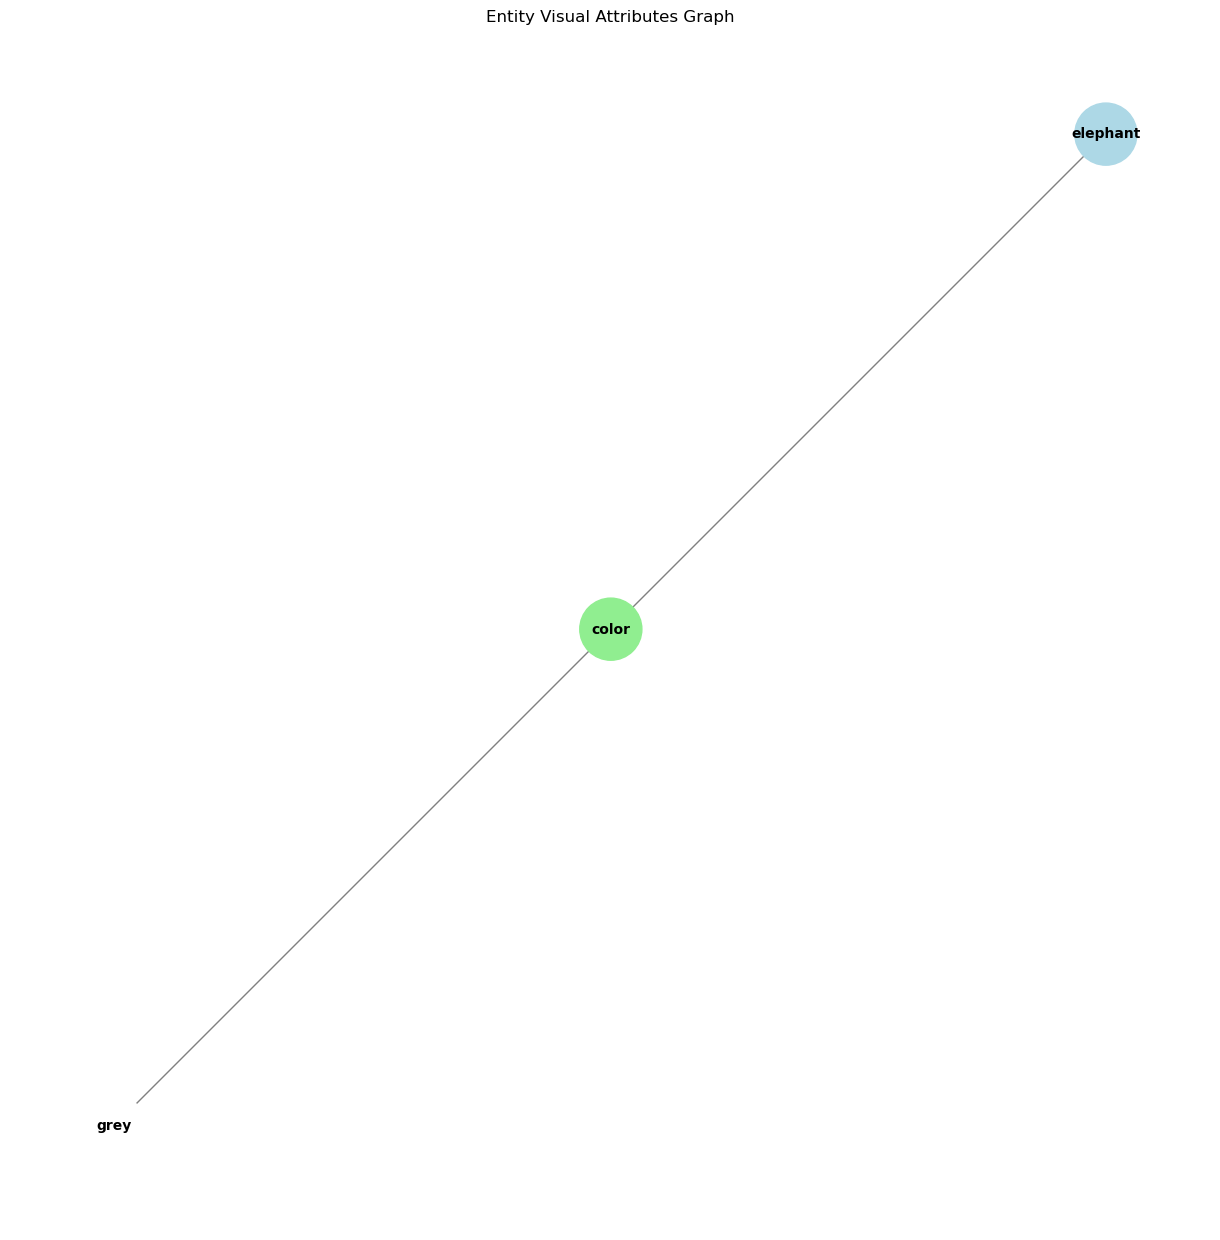

In [14]:
qid = search_entity('elephant')
graph = get_visual_attributes_graph(qid)
graph_height(graph)
visualize_graph(graph)

In [9]:
qid = search_entity('parrot')


In [10]:
graph = get_visual_attributes_graph(qid)


Height of the graph (longest path): 0


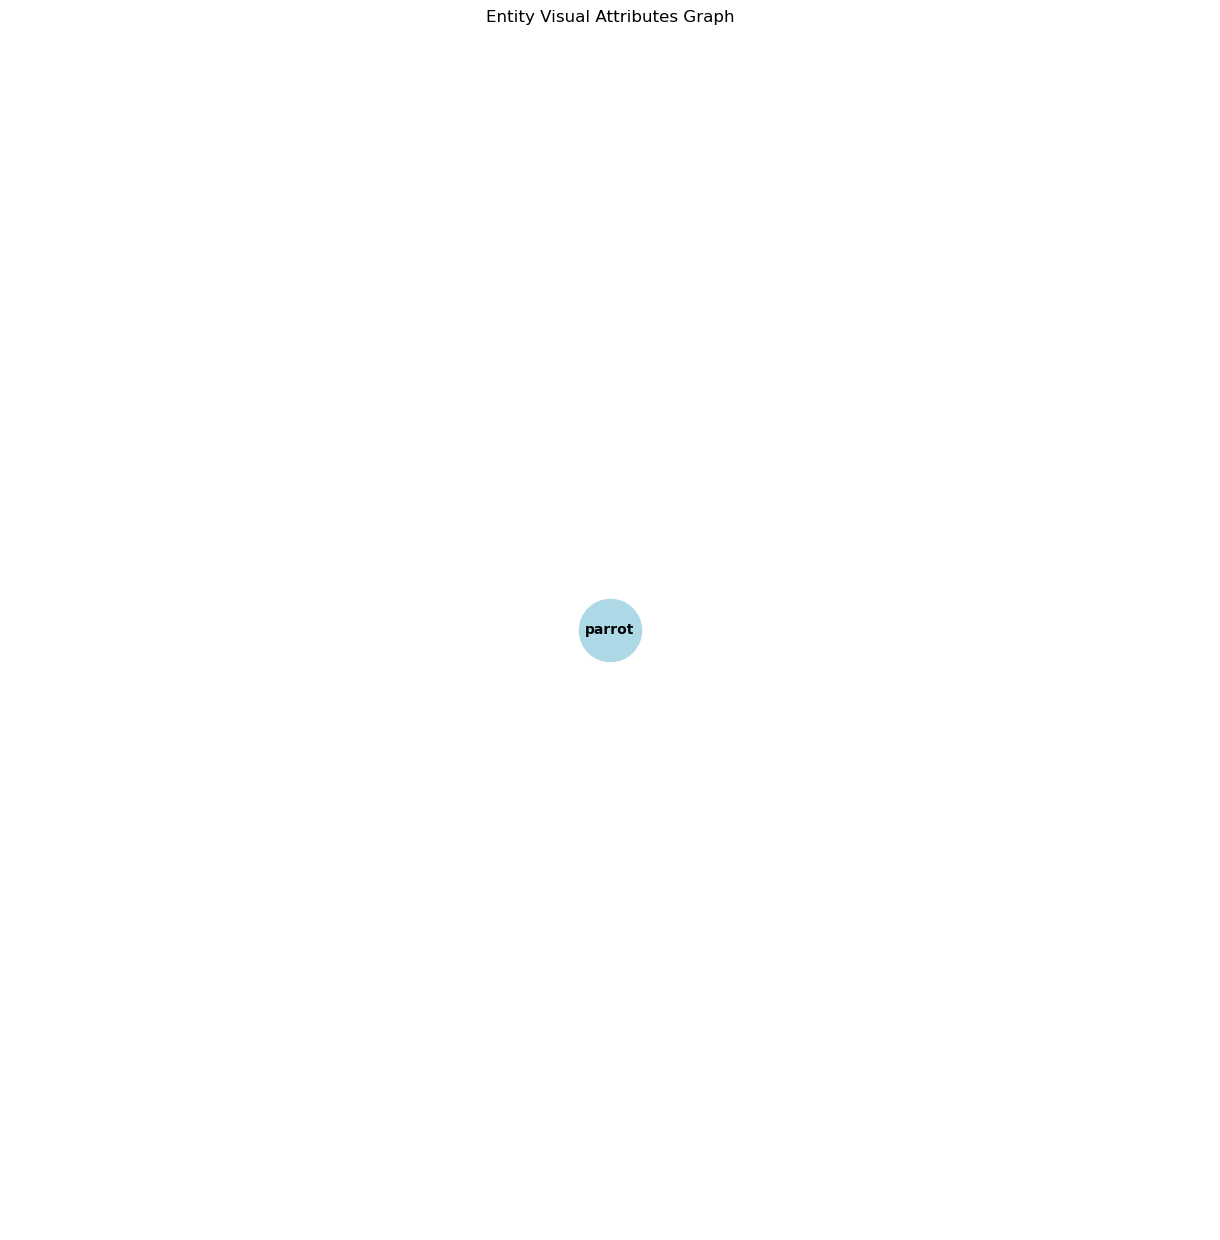

In [13]:
graph_height(graph)
visualize_graph(graph)



In [12]:
for prop in entity.properties:
    print(prop, entity['prop'], end='\n')  # Prints: "P31", "P105", etc.

NameError: name 'entity' is not defined